# Import Library

In [32]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../data"))

['.ipynb_checkpoints', 'Different-type-of-WBC.ipynb', 'model.h5', 'submission.csv', 'test', 'train']


# Define Constants

In [33]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training data

In [34]:
filenames = os.listdir("../data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'p':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

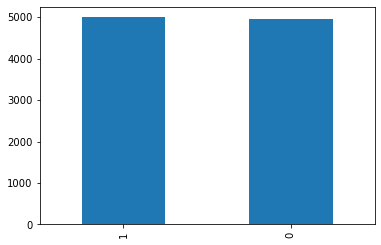

In [38]:
df['category'].value_counts().plot.bar()


# See Sample

filename  category
0     mono. (2526).jpeg         0
1     mono. (2527).jpeg         0
2     mono. (2528).jpeg         0
3     mono. (2529).jpeg         0
4     mono. (2530).jpeg         0
...                 ...       ...
9952      p. (995).jpeg         1
9953      p. (996).jpeg         1
9954      p. (997).jpeg         1
9955      p. (998).jpeg         1
9956      p. (999).jpeg         1

[9957 rows x 2 columns]

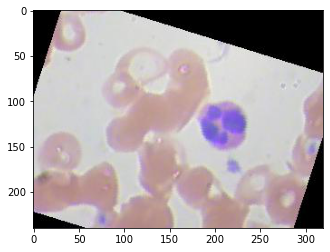

In [39]:
sample = random.choice(filenames)
image = load_img("../data/train/"+sample)
plt.imshow(image)

# Build Model

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [16]:
earlystop = EarlyStopping(patience=10)

# Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data
Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [31]:
df["category"] = df["category"].replace({0: 'Mono', 1: 'Poly'}) 
df

filename category
0     mono. (2526).jpeg     Mono
1     mono. (2527).jpeg     Mono
2     mono. (2528).jpeg     Mono
3     mono. (2529).jpeg     Mono
4     mono. (2530).jpeg     Mono
...                 ...      ...
9952      p. (995).jpeg     Poly
9953      p. (996).jpeg     Poly
9954      p. (997).jpeg     Poly
9955      p. (998).jpeg     Poly
9956      p. (999).jpeg     Poly

[9957 rows x 2 columns]

In [26]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

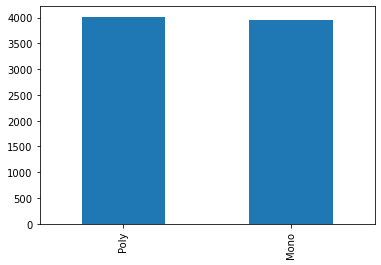

In [27]:
train_df['category'].value_counts().plot.bar()

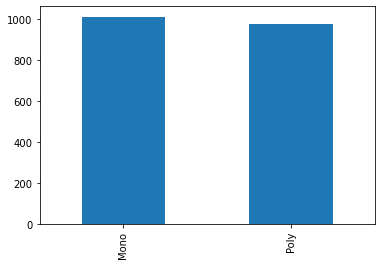

In [28]:
validate_df['category'].value_counts().plot.bar()

In [29]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 7965 validated image filenames belonging to 2 classes.


# Validation Generator

In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1992 validated image filenames belonging to 2 classes.


See how our generator work

In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


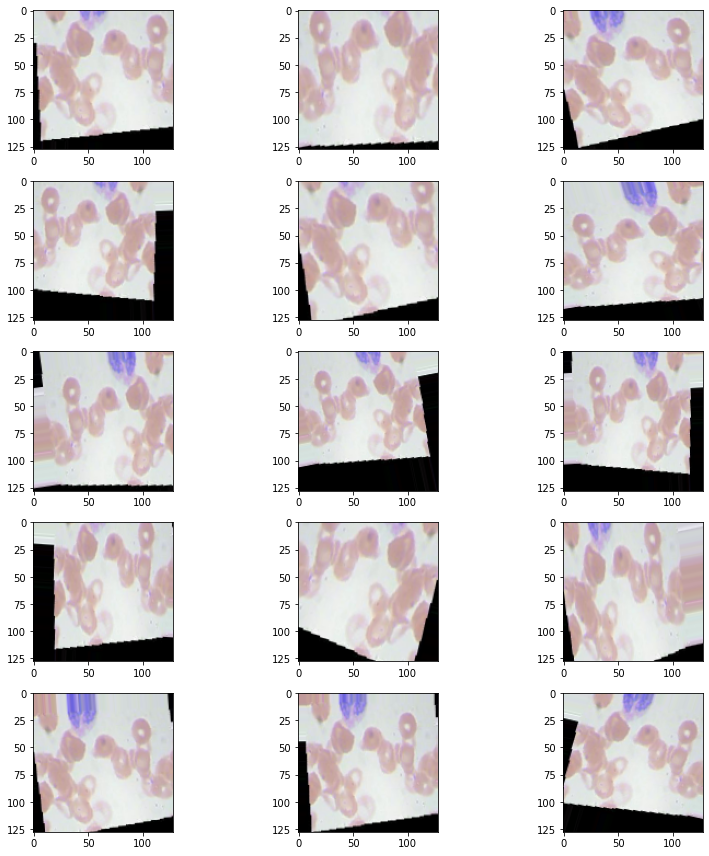

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [20]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
531/531 [==============================] - 203s 380ms/step - loss: 1.0415 - accuracy: 0.5932 - val_loss: 7.6069 - val_accuracy: 0.4924
Epoch 2/50
531/531 [==============================] - 192s 362ms/step - loss: 0.3362 - accuracy: 0.8599 - val_loss: 2.4858 - val_accuracy: 0.6258
Epoch 3/50
531/531 [==============================] - 190s 358ms/step - loss: 0.1849 - accuracy: 0.9266 - val_loss: 0.5177 - val_accuracy: 0.7222
Epoch 4/50
531/531 [==============================] - 194s 366ms/step - loss: 0.1386 - accuracy: 0.9487 - val_loss: 49.9701 - val_accuracy: 0.4899
Epoch 5/50
531/531 [==============================] - 192s 361ms/step - loss: 0.1350 - accuracy: 0.9440 - val_loss: 0.0969 - val_accuracy: 0.9631
Epoch 6/50
531/531 [==============================] - 193s 363ms/step - loss: 0.1279 - accuracy: 0.9526 - val_loss: 2.1386 - val_accuracy: 0.5798
Epoch 7/50
531/531 [==============================] - 184s 346ms/step - loss: 0.1100 - accuracy: 0.9586 - val_loss: 0.4594 

# Save Model

In [21]:
model.save_weights("model.h5")

# Virtualize Training

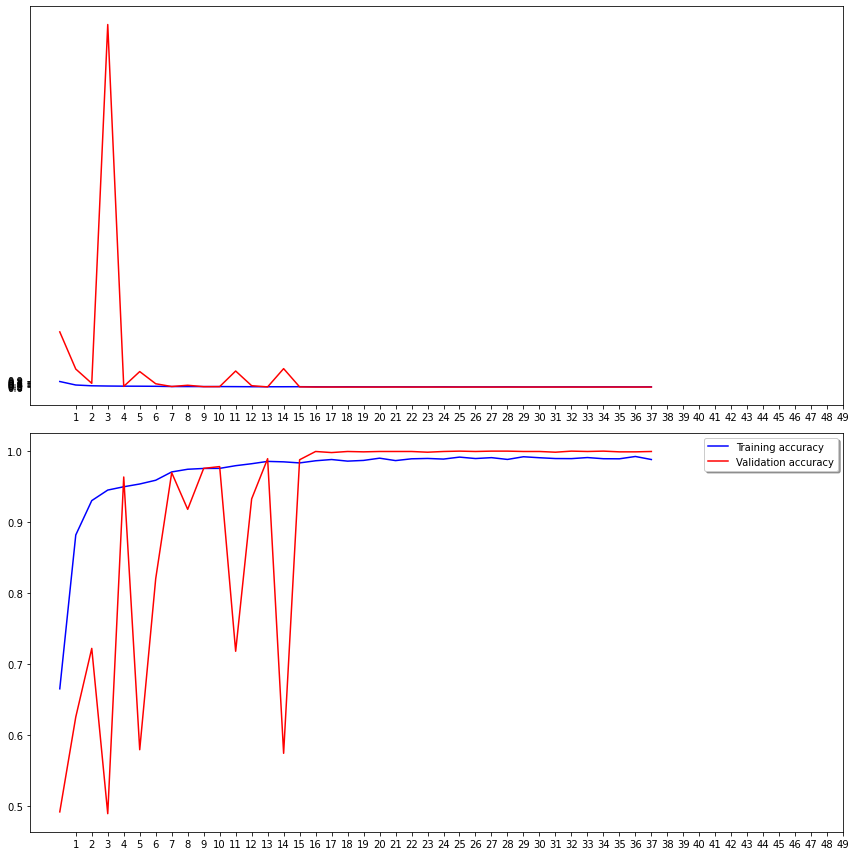

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [23]:
test_filenames = os.listdir("../data/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [24]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2476 validated image filenames.


# Predict

In [25]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [26]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [27]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [28]:
test_df['category'] = test_df['category'].replace({ 'Poly': 1, 'Mono': 0 })

# Virtaulize Result

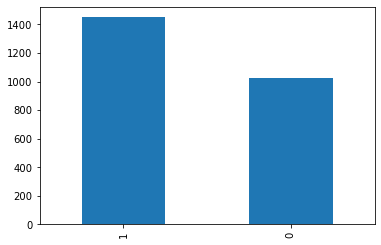

In [29]:
test_df['category'].value_counts().plot.bar()

In [33]:
Poly = test_df[test_df['category']==1]
Mono = test_df[test_df['category']==0]


# See predicted result with images

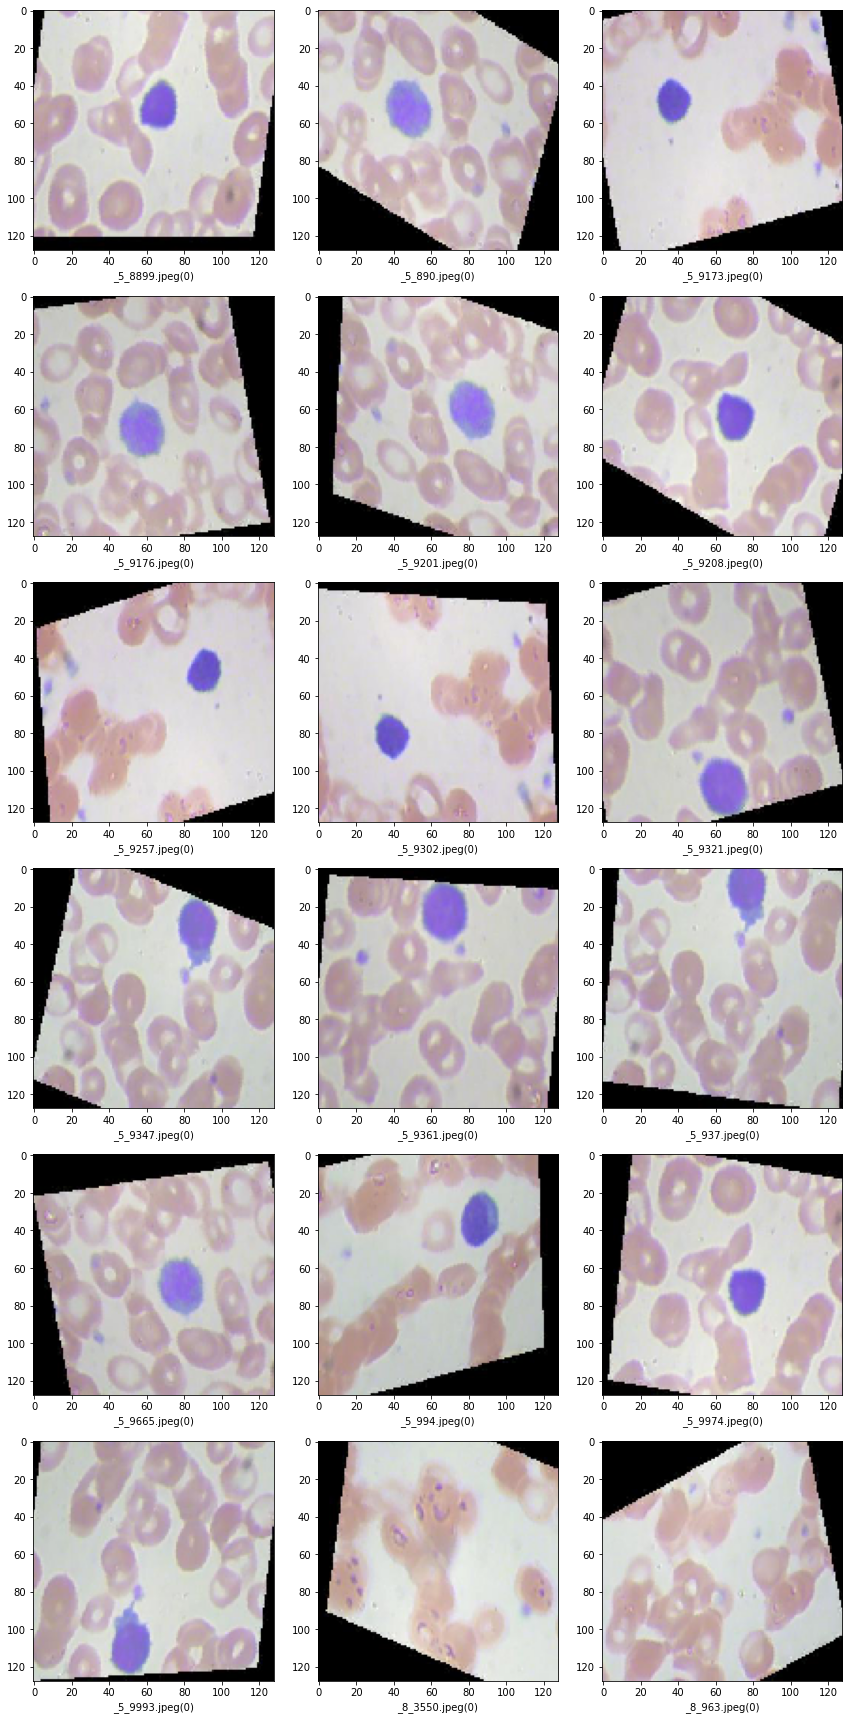

In [42]:
sample_test =Mono.tail(18).reset_index()
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

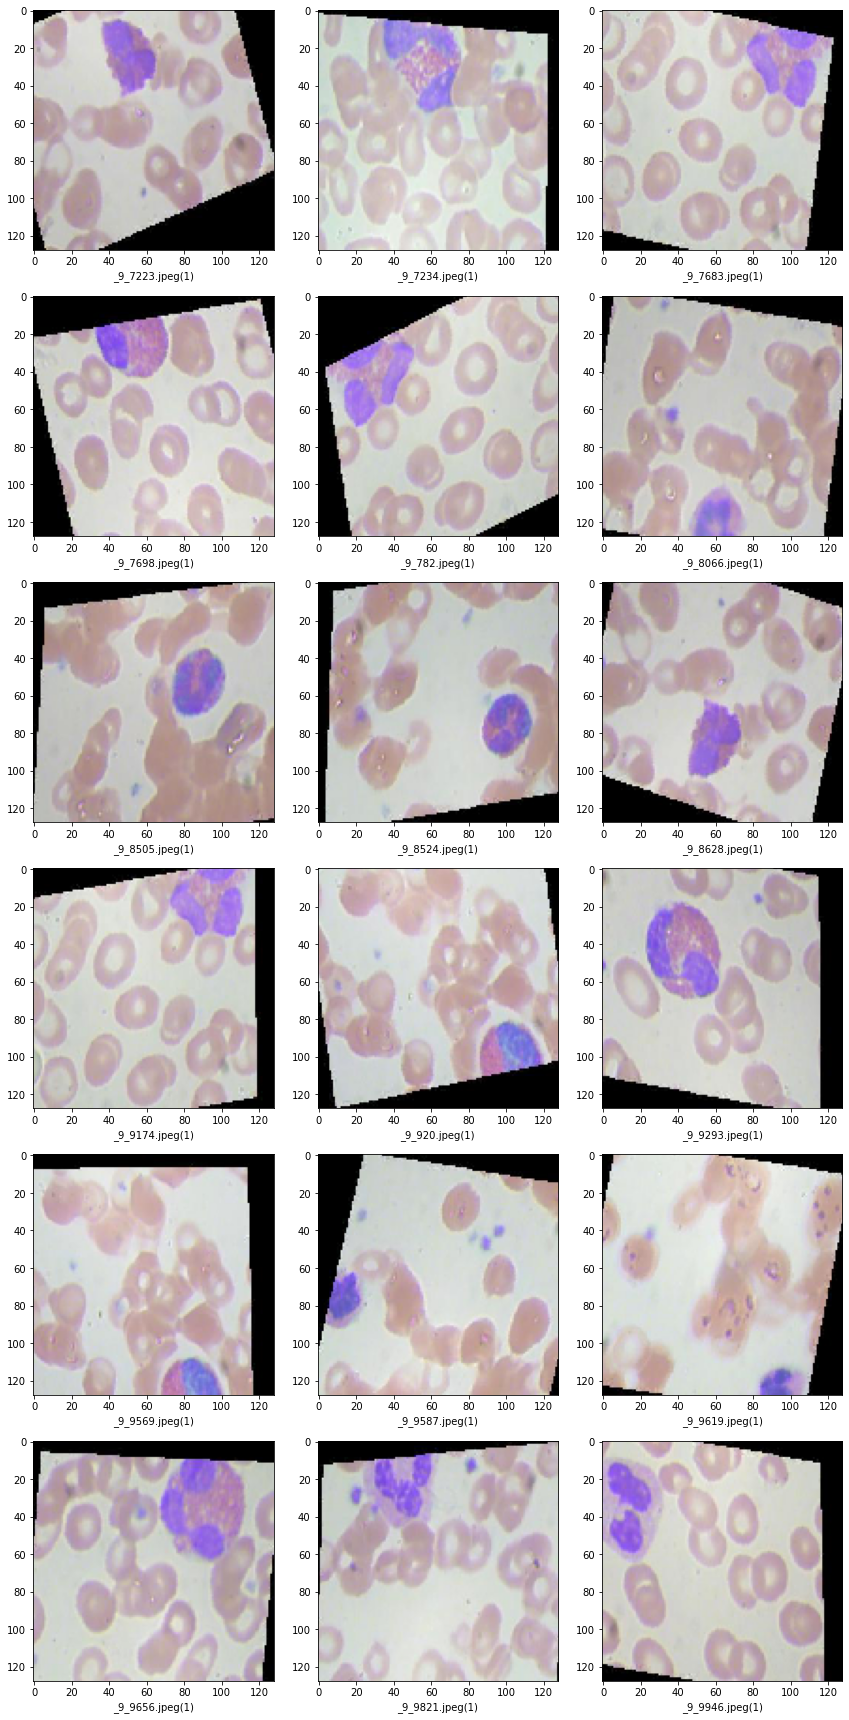

In [43]:
sample_test =Poly.tail(18).reset_index()
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

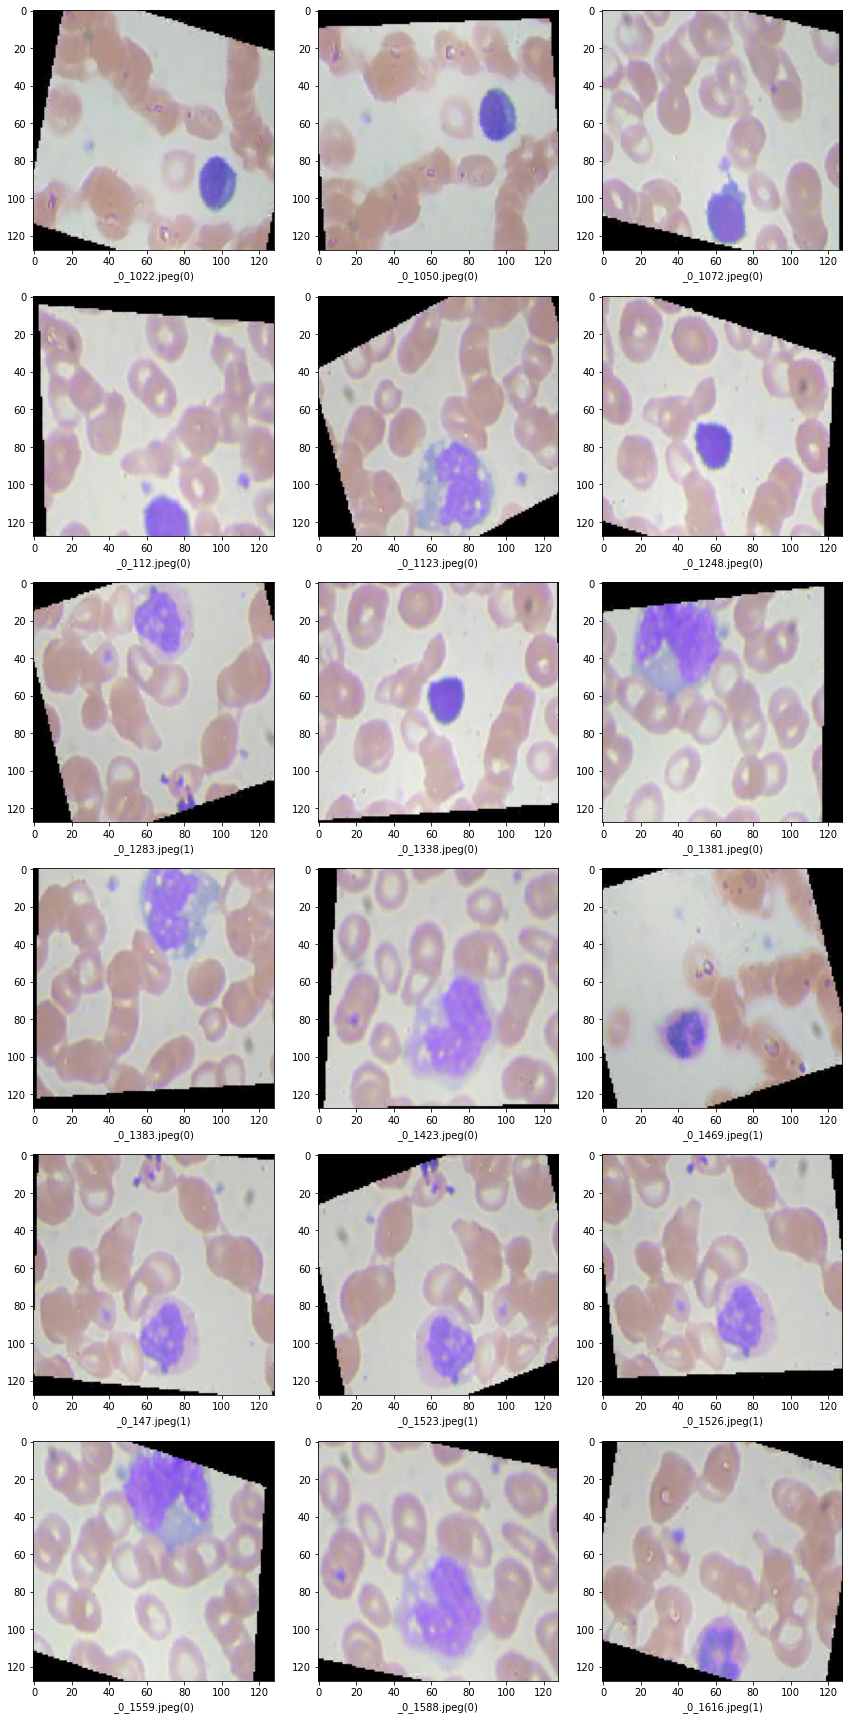

In [30]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [31]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)